## XGBoost hyperparameter tuning

The purpose of this notebook is to demonstrate XGB hyperparameter tuning using optimization (hyperopt module) technique. The best set of hyperparameters is then used to generate predictions by store by item.

## 00. import required modules

In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import cross_val_score

from datetime import datetime

import xgboost as xgb
import hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from matplotlib import pyplot as plt
%matplotlib inline

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

## 01. output files path (/models/< date of modeling > subfolder

In [2]:
model_date = datetime.today().strftime('%Y-%m-%d')
path = "../models/{}/".format(model_date)
if not os.path.exists(path):
    os.makedirs(path)

## 02. import data

In [3]:
train_data=pd.read_csv('../data/processed/df_train_train.csv.gz')
test_data=pd.read_csv('../data/processed/df_train_test.csv.gz')

In [4]:
print(train_data.shape,test_data.shape)

(730500, 135) (182500, 135)


In [5]:
train_data.head()

,date,sales,year,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_0,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,week_10,week_11,week_12,week_13,week_14,week_15,week_16,week_17,week_18,week_19,week_20,week_21,week_22,week_23,week_24,week_25,week_26,week_27,week_28,week_29,week_30,week_31,week_32,week_33,week_34,week_35,week_36,week_37,week_38,week_39,week_40,week_41,week_42,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51,week_52,week_53,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2013-01-01,2.639057,2013,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2013-01-02,2.484907,2013,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2013-01-03,2.708050,2013,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,2013-01-04,2.639057,2013,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,2013-01-05,2.397895,2013,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


## 03. creating feature list and train/test target variables and features

In [6]:
list_cols=train_data.columns.tolist()

In [7]:
#target column
target_col = ['sales']

In [8]:
list_cols

['date',
 'sales',
 'year',
 'store_1',
 'store_2',
 'store_3',
 'store_4',
 'store_5',
 'store_6',
 'store_7',
 'store_8',
 'store_9',
 'store_10',
 'item_1',
 'item_2',
 'item_3',
 'item_4',
 'item_5',
 'item_6',
 'item_7',
 'item_8',
 'item_9',
 'item_10',
 'item_11',
 'item_12',
 'item_13',
 'item_14',
 'item_15',
 'item_16',
 'item_17',
 'item_18',
 'item_19',
 'item_20',
 'item_21',
 'item_22',
 'item_23',
 'item_24',
 'item_25',
 'item_26',
 'item_27',
 'item_28',
 'item_29',
 'item_30',
 'item_31',
 'item_32',
 'item_33',
 'item_34',
 'item_35',
 'item_36',
 'item_37',
 'item_38',
 'item_39',
 'item_40',
 'item_41',
 'item_42',
 'item_43',
 'item_44',
 'item_45',
 'item_46',
 'item_47',
 'item_48',
 'item_49',
 'item_50',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6',
 'weekday_0',
 'week_1',
 'week_2',
 'week_3',
 'week_4',
 'week_5',
 'week_6',
 'week_7',
 'week_8',
 'week_9',
 'week_10',
 'week_11',
 'week_12',
 'week_13',
 'week_14',
 'w

In [9]:
#feature list (store and item ids excluded)
ft_list=[
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6',
 'weekday_0',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
'week_1',
 'week_2',
 'week_3',
 'week_4',
 'week_5',
 'week_6',
 'week_7',
 'week_8',
 'week_9',
 'week_10',
 'week_11',
 'week_12',
 'week_13',
 'week_14',
 'week_15',
 'week_16',
 'week_17',
 'week_18',
 'week_19',
 'week_20',
 'week_21',
 'week_22',
 'week_23',
 'week_24',
 'week_25',
 'week_26',
 'week_27',
 'week_28',
 'week_29',
 'week_30',
 'week_31',
 'week_32',
 'week_33',
 'week_34',
 'week_35',
 'week_36',
 'week_37',
 'week_38',
 'week_39',
 'week_40',
 'week_41',
 'week_42',
 'week_43',
 'week_44',
 'week_45',
 'week_46',
 'week_47',
 'week_48',
 'week_49',
 'week_50',
 'week_51',
 'week_52']

In [10]:
#train data
y = train_data[target_col].values
x = train_data[ft_list]

In [11]:
#test data
ytest = test_data[target_col].values
xtest = test_data[ft_list]

In [12]:
print(x.shape, xtest.shape)

(730500, 71) (182500, 71)


## 04. baseline code for tuning

In [13]:
eval_score_list=[]#list of evaluation scores
def objective(space):
    
    clf = xgb.XGBRegressor(n_estimators=space['n_estimators'], #number of trees to fit; shouldn't exceed # of features 
                           colsample_bytree=space['colsample_bytree'], #subsample ratio of features when constructing each tree
                           min_child_weight = space['min_child_weight'], #minimum sum of instance weight needed in a child: for regularization and limiting tree depth
                           learning_rate =space['learning_rate'], #boosting learning rate (eta): weighting factor for the corrections by new trees when added to the model tp avoid overfitting
                           max_depth = int(space['max_depth']), #max tree depth for base learners
                           subsample = space['subsample'], #subsample ratio of training data
                           gamma = space['gamma'],#min loss reduction required to make a further partition on a leaf node of the tree: for regularization
                           reg_lambda = space['reg_lambda'],#L2 regularization on weights (encorages weights to be small)
                           n_jobs=4, #number of parallel threads used to run xgboost
                           objective='reg:squarederror') #regression with squared loss
    
    #we use cross-validation wth the default (5-fold) splitting strategy 
    eval_score = -1*cross_val_score(clf, x, y, scoring='neg_root_mean_squared_error').mean()
    #note: sklearn has only negative rmse metrics built-in; we multiply it by -1 to convert to positive 
    #and further minimize rmse by fmin objective function from hyperopt
    print("root_mean_squared_error {:.3f} params {}".format(eval_score, space))
    
    eval_score_list.append(eval_score)
    return {'loss':eval_score, 'status': STATUS_OK }

## 05. hyperparameter space

In [14]:
space ={'max_depth': hp.quniform("x_max_depth", 3, 16, 1), 
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1), 
        'subsample': hp.uniform ('x_subsample', 0.7, 1),
        'gamma' : hp.uniform ('x_gamma', 0.1,0.5),
        'colsample_bytree' : hp.uniform ('x_colsample_bytree', 0.7,1),
        'reg_lambda' : hp.uniform ('x_reg_lambda', 1,20),
        'learning_rate':hp.uniform('x_eta',0.1,1.5),
        'n_estimators' : hp.choice('n_estimators', np.arange(int(len(ft_list)/2), len(ft_list), 1, dtype=int))}

## 06. hyperopt tunning for the best hyperparameters

In [15]:
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

root_mean_squared_error 0.534 params {'colsample_bytree': 0.8048048285696201, 'gamma': 0.1503684577363912, 'learning_rate': 1.4148087198407342, 'max_depth': 4.0, 'min_child_weight': 6.0, 'n_estimators': 42, 'reg_lambda': 5.3577545976532885, 'subsample': 0.7791351992082459}
root_mean_squared_error 0.534 params {'colsample_bytree': 0.9268618592427125, 'gamma': 0.45951266589881123, 'learning_rate': 1.0043071434853124, 'max_depth': 7.0, 'min_child_weight': 9.0, 'n_estimators': 42, 'reg_lambda': 4.612824417142783, 'subsample': 0.7565100221201032}
root_mean_squared_error 0.534 params {'colsample_bytree': 0.7610287913788641, 'gamma': 0.13042498407699907, 'learning_rate': 0.734920944160677, 'max_depth': 11.0, 'min_child_weight': 10.0, 'n_estimators': 44, 'reg_lambda': 7.231454040812848, 'subsample': 0.8866795679003642}
root_mean_squared_error 0.534 params {'colsample_bytree': 0.9038559467073539, 'gamma': 0.16502043993645912, 'learning_rate': 0.44401056808491424, 'max_depth': 9.0, 'min_child_we

## 07. best hyperparameters

In [16]:
#best hyperparameters set
best=hyperopt.space_eval(space,best)
best

{'colsample_bytree': 0.835779734148635,
 'gamma': 0.12642119210961245,
 'learning_rate': 0.5219300876630867,
 'max_depth': 15.0,
 'min_child_weight': 9.0,
 'n_estimators': 46,
 'reg_lambda': 9.176786015649471,
 'subsample': 0.859209523922442}

In [17]:
print('train eval metrics (rmse) ',min(eval_score_list))

train eval metrics (rmse)  0.5335242940712421


In [18]:
# export best eval metrics list as pickle
pd.to_pickle(min(eval_score_list),path+'best_eval_metrics.pickle')

In [19]:
# export best hyperparams as pickle
pd.to_pickle(best,path+'best_param.pickle')

## 08. training final model with the best hyperparameters

In [20]:
clf = xgb.XGBRegressor(n_estimators=best['n_estimators'],colsample_bytree=best['colsample_bytree'],
                       learning_rate = best['learning_rate'],
                       max_depth = int(best['max_depth']),
                       min_child_weight = best['min_child_weight'],
                       subsample = best['subsample'],
                       gamma = best['gamma'],
                       n_jobs=4,
                       reg_lambda = best['reg_lambda'],objective='reg:squarederror')


clf.fit(x, y,verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.835779734148635,
             gamma=0.12642119210961245, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.5219300876630867,
             max_delta_step=0, max_depth=15, min_child_weight=9.0, missing=nan,
             monotone_constraints='()', n_estimators=46, n_jobs=4,
             num_parallel_tree=1, random_state=0, reg_alpha=0,
             reg_lambda=9.176786015649471, scale_pos_weight=1,
             subsample=0.859209523922442, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [21]:
# export the model
pd.to_pickle(clf,path+'model.pickle')

In [22]:
# use the model to predict test
predictions=clf.predict(xtest)
predictions=pd.DataFrame(predictions)
actuals=pd.DataFrame(ytest)
# put preds and actual values side by side
predictions_actuals=pd.merge(predictions,actuals,left_index=True,right_index=True).rename(columns={'0_x':'predictions','0_y':'actuals'})

In [23]:
# calculate accuracy score
eval_metrics_test=np.sqrt(mean_squared_error(predictions_actuals['actuals'], predictions_actuals['predictions']))

In [24]:
print('test eval metrics (rmse) ',eval_metrics_test)

test eval metrics (rmse)  0.5342034601800382


In [25]:
#observation: train and test rmse are close to each other

In [26]:
#export test predictions and actuals
predictions_actuals.to_csv(path+'test_preds_actuals.csv.gz',compression='gzip',index=False)

In [27]:
#export test eval metrics
pd.to_pickle(eval_metrics_test,path+'eval_metrics_test.pickle')

## 09. feature importance

      feature  importance
0    month_12    0.266439
1     month_1    0.239275
2     month_2    0.236222
3     month_3    0.064011
4   weekday_0    0.050983
5     month_7    0.032179
6     month_6    0.019373
7   weekday_6    0.019350
8   weekday_2    0.009159
9   weekday_1    0.008228
10    month_8    0.008153
11    month_5    0.006550
12  weekday_3    0.005417
13  weekday_5    0.004891
14   month_10    0.004373


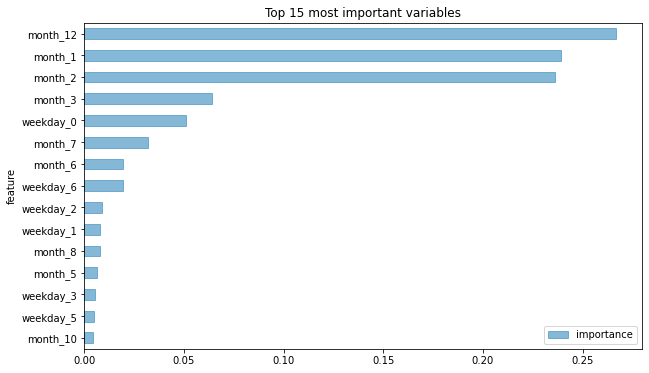

In [28]:
feature_importances_data = []
features = x.columns
for feature_name, feature_importance in zip(features, clf.feature_importances_):
    feature_importances_data.append({
        'feature': feature_name,
        'importance': feature_importance
    })

# Plot the results
top15_fea = pd.DataFrame(feature_importances_data)\
    .set_index('feature')\
    .sort_values(by='importance')[-15::]\

print(top15_fea.sort_values('importance',ascending=False).reset_index())

top15_fea.plot(title='Top 15 most important variables',
          kind='barh',
          figsize=(10, 6),
          color='#348ABD',
          alpha=0.6,
          lw='1',
          edgecolor='#348ABD',
          grid=False,)

In [29]:
#observation: months (Jan, Feb, Dec) are the most important features as it was noted during the EDA stage

In [30]:
#export feature importance
feature_imp=pd.DataFrame(feature_importances_data)
feature_imp.sort_values('importance',ascending=False,inplace=True)
feature_imp.to_csv(path+'feature_importance.csv', index=False)